### Requirements

#### Python packages
- [cython](https://pypi.org/project/Cython/)
- [MDAnalysis](https://pypi.org/project/MDAnalysis/)
- [periodictable](https://pypi.org/project/periodictable/)
- [matplotlib](https://pypi.org/project/matplotlib/)


### Requirements

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.ion()
import numpy as np
import MDAnalysis as mda
import periodictable
import nsc

/home/jbq/.virtualenvs/nsc3.6/lib/python3.6/site-packages/MDAnalysis/due.py:88: UserWarning: No module named 'duecredit'
  warnings.warn(str(err))


### Utility functions

In [21]:
def single_plot(x, y, xlabel='x', ylabel='y', xscale='linear', yscale='linear', plotkwargs=None):
    """Matplotlib figure
    xscale: str
        Either 'linear' or 'log'
    plotkwargs: dict
        Additional arguments to matplotlib.axes.Axes.plot()
    """
    if plotkwargs is None:
        plotkwargs = dict()
    fig, ax = plt.subplots(1,1)
    ax.plot(x, y, **plotkwargs)
    ax.set_xlabel(xlabel, size=25)
    ax.set_ylabel(ylabel, size=25)
    ax.set_yscale(yscale)
    ax.set_xscale(xscale)
    plt.tight_layout()
    plt.show()

### Download water simulation
`wget` and `tar` commands are necessary.  
You may skip this step if running the notebook more than once

In [2]:
%%capture
%%bash
wget https://www.dropbox.com/s/au6k0m84kggq057/water.tar
tar xf water.tar

### Create system and extract coordinates

In [3]:
%%capture
u = mda.Universe("water/npt.gro", "water/nvt.trr")

`u` is a `MDAnalysis.Universe` object. It contains 512 TIP4P water molecules. Each TIP4P water molecule is composed of one oxygen, two hydrogens, and two lone-pair electrons.

In [4]:
print('number of residues =', len(u.residues))
print('Atoms in the first water molecule', u.atoms[0:4])

number of residues = 512
Atoms in the first water molecule <AtomGroup [<Atom 1: OW of type O of resname SOL, resid 1 and segid SYSTEM>, <Atom 2: HW1 of type H of resname SOL, resid 1 and segid SYSTEM>, <Atom 3: HW2 of type H of resname SOL, resid 1 and segid SYSTEM>, <Atom 4: LP1 of type L of resname SOL, resid 1 and segid SYSTEM>]>


Select only the hydrogens and oxygens. There should be three atoms per water molecule

In [5]:
sel = u.select_atoms('type H or type O')
print('number of atoms per water molecule = ', len(sel)/len(u.residues))

number of atoms per water molecule =  3.0


Obtain the bound coherent neutron scattering lengths for the atoms of our selection `sel`.

In [6]:
b_c = np.asarray([getattr(periodictable, at.type).neutron.b_c  for at in sel])

In [7]:
print(b_c)  # units in fm

[ 5.805  -3.7409 -3.7409 ...  5.805  -3.7409 -3.7409]


We investigate the trajectory.

In [8]:
print('number of conformations =', u.trajectory.n_frames)
print('Size of the box, in Angstroms =', u.dimensions[0:3])
print('It is a cubic box, as evidenced by the angles between box sides: ',u.dimensions[3:])

number of conformations = 5001
Size of the box, in Angstroms = [24.893501 24.893501 24.893501]
It is a cubic box, as evidenced by the angles between box sides:  [90. 90. 90.]


We will calculate the structure factor for 1000 conformations, out of the 5001. We extract one conformation every 5. We only care about the hydrogen and oxygen atoms of our selection `sel`.

In [9]:
tr = np.asarray([sel.positions for _ in u.trajectory[0:-1:5]])  # from beginning (0) to end (-1) every 5
print(tr.shape)  #  1000 conformations, 1536 atoms per conformation, 3 coordinates (x, y, z) per atoms

(1000, 1536, 3)


### Calculate the coherent static structure factor `S(q)`

We first generate 200 momentum transfer moduli from `0` to `5.0` (will be stored in array `q_mod`). Then for each modulus we generate 100 momentum transfer vectors with random orientations but all with the same modulus (array `q_vec`).

After generation of the momentum transfer vector set, we can calculate `S(q)`, the scattering for each momentum transfer modulus. We also need the scattering lengths and the coordinates of the atoms of interest.

In [23]:
q_mod = nsc.qvec.moduli_linscale(q_mod_min=0, q_mod_max=5.0, n_q_mod=200)  # list of q moduli
q_vec = nsc.qvec.sphere_average(q_mod, nvec=100)  

In [24]:
s = nsc.elastic.structure_factor.structure_factor(q_vec, tr, b_c)

100%|██████████| 200/200 [36:51<00:00, 11.06s/it]


<IPython.core.display.Javascript object>


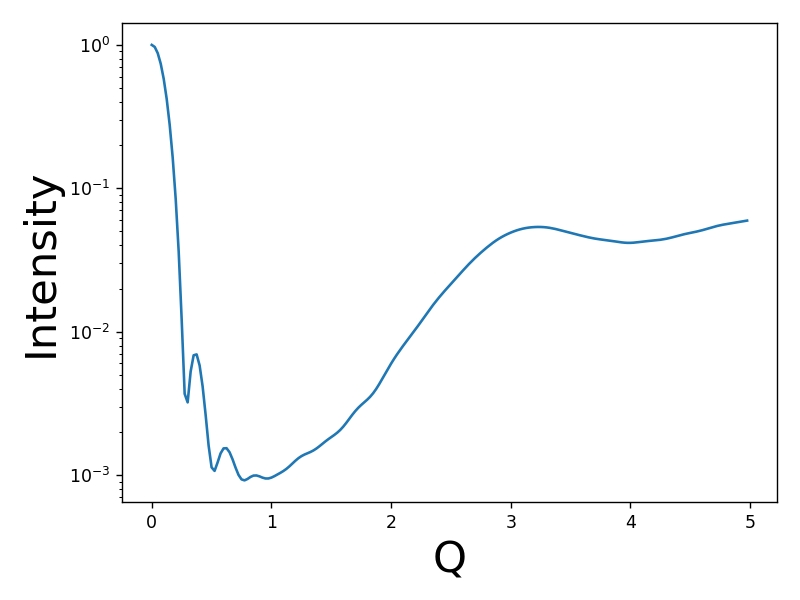

In [25]:
single_plot(q_mod, s, xlabel='Q', ylabel='Intensity', xscale='linear', yscale='log')

### Calculate the coherent static structure factor `S(q)` in a log scale

Extending to high `q` on a linear scale takes very long time. Thus, a log-scale is a reasonable sampling for large ranges of momemtum transfer.

Very similar calculations as in the linear scale. In this case we generate momentum transfer moduli in a logarithmic scale in base 10, starting from `1.0` and up to `100.0`, thus spanning two decades. We will create 100 different moduli per decade.

In [26]:
q_mod_log = nsc.qvec.moduli_logscale(min_exp=0, max_exp=2, n_per_base=100, base=10)  # list of q moduli
q_vec_log = nsc.qvec.sphere_average(q_mod_log, nvec=100)  # random orientations

In [29]:
s_log = nsc.elastic.structure_factor.structure_factor(q_vec_log, tr, b_c)

100%|██████████| 200/200 [35:38<00:00, 10.69s/it]


<IPython.core.display.Javascript object>


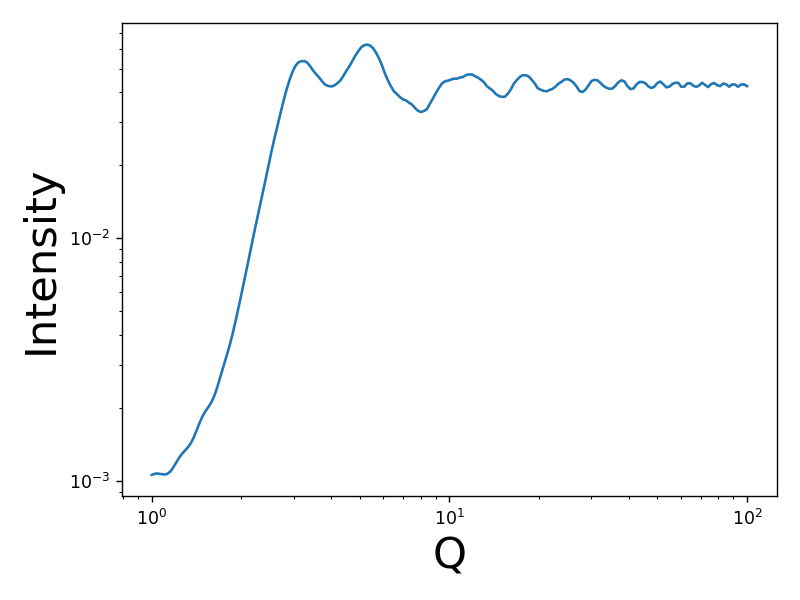

In [30]:
single_plot(q_mod_log, s_log, xlabel='Q', ylabel='Intensity', xscale='log', yscale='log')